# Delay Embedding Reconstruction of HH Neuron
A single Hodgkin-Huxley neuron driven by constant input is a 4-dimensonal system, and it revolves around a limit cycle when the input is suprathreshold. Can we retrieve the dimensionality of the system when measuring Vm?

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import neurodynex.tools.input_factory as input_factory
import pyEDM as edm
import sys
sys.path.append('../')
import nlds.delayembed as de

In [2]:
def simulate_HH_neuron(input_current, simulation_time):
    # function taken from neurodynex.hodkin_huxley: 
    # https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex/hodgkin_huxley/HH.html
    # Gerstner, Kistler, Naurd & Paninski
        
    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

In [25]:
#current = input_factory.get_step_current(10, 970, b2.ms, 7.2 * b2.uA)
sine_current = input_factory.get_sinusoidal_current(0, 1000, b2.ms, 2 * b2.uA, 40*b2.Hz, 8 * b2.uA)
state_monitor = simulate_HH_neuron(sine_current, 1000 * b2.ms)

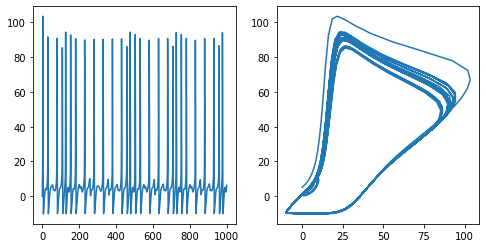

In [26]:
delay=8
t_sim = state_monitor.t/b2.ms
vm_sim = state_monitor.vm[0]/b2.mV
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(t_sim, vm_sim)
plt.subplot(1,2,2)
plt.plot(vm_sim[:-delay], vm_sim[delay:])


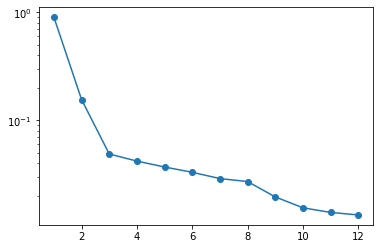

In [27]:
max_dim = 12
t_MI, MI = de.compute_delay_MI(vm_sim, 40, 30)
v_ind, v_val = de.find_valley(MI)
data_embed = de.delay_embed(vm_sim,v_ind,8)

# plt.plot(t_MI, MI)
# plt.plot(v_ind, v_val, 'o')
embed_dim, pfnn = de.PFNN(vm_sim, v_ind, max_dim)
plt.plot(range(1,max_dim+1), pfnn, 'o-')
plt.yscale('log')

In [6]:
edm.Embed

<function pyEDM.CoreEDM.Embed>

In [9]:
edm.CoreEDM??